In [179]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [181]:
df = pd.read_csv('datasets/готовая_кластеризация.csv')
df.head()

,Ученик,Средний балл за Сентябрь,Средний балл за Октябрь,Средний балл за Ноябрь,Средний балл за Декабрь,Средний балл за Январь,Средний балл за Февраль,Средний балл за Март,Средний балл за Апрель,Средний балл за Май,...,Общее кол-во 3 за 2 полугодие,Общее кол-во 2 за 2 полугодие,Общее кол-во У за 2 полугодие,Общее кол-во Б за 2 полугодие,Общее кол-во Н за 2 полугодие,Среднее кол-во У в месяц,Среднее кол-во Б в месяц,Среднее кол-во Н в месяц,Успешный (нет предмета со ср. баллом < 3.5),Успешный (по итогам кластеризации)
0,Ученик 1_8A,3.807018,3.600000,3.852941,3.666667,3.902439,3.839286,3.800000,3.830000,3.860000,...,61,7,0,126,21,2.111111,20.333333,2.555556,0,0
1,Ученик 2_8A,3.382979,3.212121,3.483871,3.316667,3.342857,3.300000,3.150000,3.261905,3.304878,...,115,26,11,64,25,4.888889,13.777778,2.888889,0,0
2,Ученик 3_8A,2.965517,2.972222,3.085366,3.166667,3.150000,3.048077,3.089744,3.108696,3.317073,...,132,48,7,0,8,3.250000,7.250000,1.125000,0,0
3,Ученица 4_8A,3.842593,3.702703,3.646341,3.576923,3.566667,3.518182,3.750000,3.525000,4.015152,...,85,18,39,0,8,11.500000,3.375000,1.000000,0,0
4,Ученик 5_8A,3.298246,3.076923,3.160377,3.350000,3.222222,3.163636,3.104167,3.238806,3.400000,...,115,33,28,46,12,11.500000,8.125000,1.500000,0,0


In [183]:
month_columns = [
    "Средний балл за Сентябрь", "Средний балл за Октябрь", "Средний балл за Ноябрь",
    "Средний балл за Декабрь", "Средний балл за Январь", "Средний балл за Февраль",
    "Средний балл за Март", "Средний балл за Апрель", "Средний балл за Май"
]

rows = []
for _, row in df.iterrows():
    for month_col in month_columns:
        rows.append({
            "Средний балл": row[month_col],
            "Среднее кол-во У в месяц": row["Среднее кол-во У в месяц"],
            "Среднее кол-во Б в месяц": row["Среднее кол-во Б в месяц"],
            "Среднее кол-во Н в месяц": row["Среднее кол-во Н в месяц"],
            "Успешный": row["Успешный (по итогам кластеризации)"]
        })

result_df = pd.DataFrame(rows)
result_df

,Средний балл,Среднее кол-во У в месяц,Среднее кол-во Б в месяц,Среднее кол-во Н в месяц,Успешный
0,3.807018,2.111111,20.333333,2.555556,0
1,3.600000,2.111111,20.333333,2.555556,0
2,3.852941,2.111111,20.333333,2.555556,0
3,3.666667,2.111111,20.333333,2.555556,0
4,3.902439,2.111111,20.333333,2.555556,0
...,...,...,...,...,...
859,4.672414,4.600000,1.200000,1.000000,1
860,4.793103,4.600000,1.200000,1.000000,1
861,4.764706,4.600000,1.200000,1.000000,1
862,4.600000,4.600000,1.200000,1.000000,1


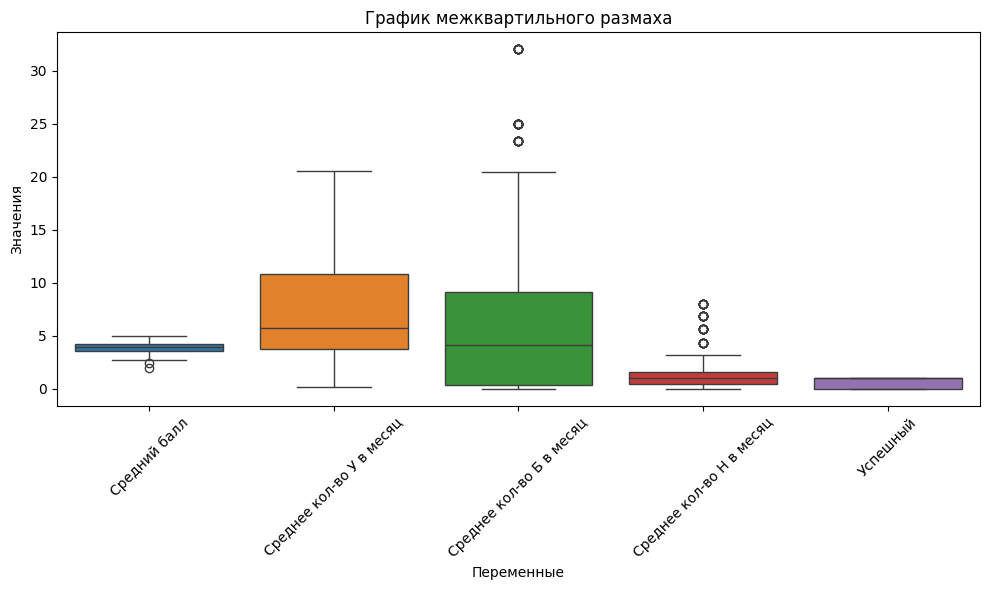

In [185]:
numeric_cols = result_df.select_dtypes(include=['number']).columns

# Постройте boxplot для каждого числового столбца
plt.figure(figsize=(10, 6))  # Установите размер графика
sns.boxplot(data=result_df[numeric_cols])
plt.title('График межквартильного размаха')
plt.ylabel('Значения')
plt.xlabel('Переменные')
plt.xticks(rotation=45)  # Поверните подписи оси x для лучшей читаемости
plt.tight_layout()  # Улучшите размещение элементов графика
plt.show()

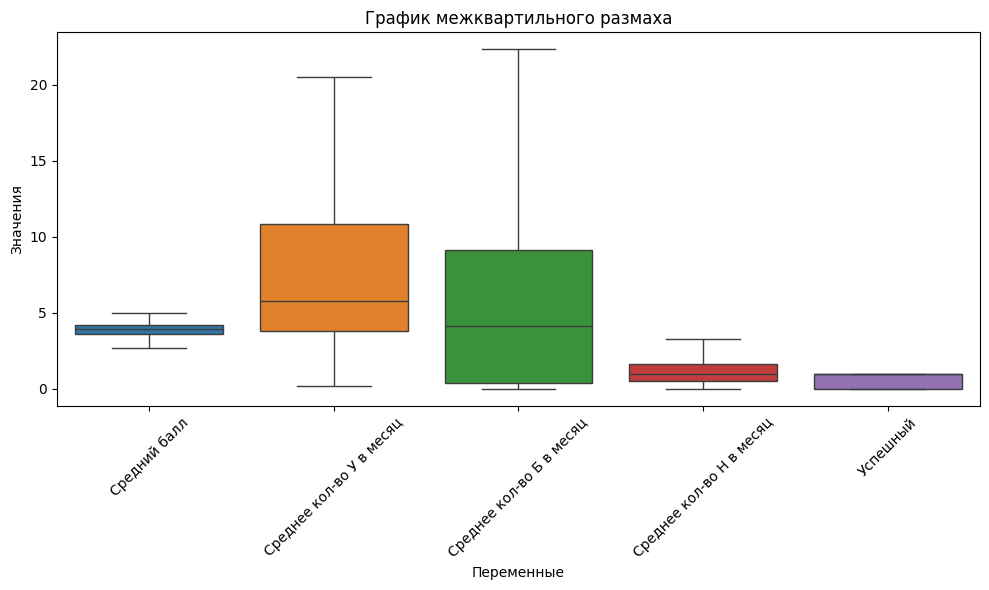

In [269]:
def calculate_outliers(col):
    inter_quantile = col.quantile(0.75) - col.quantile(0.25)
    lower_border = col.quantile(0.25) - inter_quantile * 1.5
    upper_border = inter_quantile * 1.5 + col.quantile(0.75)
    return lower_border, upper_border

cols_to_prepare = result_df.drop(columns=['Среднее кол-во У в месяц', 'Успешный']).columns
for col in cols_to_prepare:
    lower, upper = calculate_outliers(result_df[col])
    result_df.loc[result_df[col] < lower, col] = lower
    result_df.loc[result_df[col] > upper, col] = upper
    
plt.figure(figsize=(10, 6))
sns.boxplot(data=result_df[numeric_cols])
plt.title('График межквартильного размаха')
plt.ylabel('Значения')
plt.xlabel('Переменные')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [189]:
X = result_df[['Средний балл', 'Среднее кол-во У в месяц', 'Среднее кол-во Б в месяц', 'Среднее кол-во Н в месяц']]
y = result_df['Успешный']

# Шаг 3: Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 4: Инициализация и обучение StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Логируем скалер (вне MLflow run, чтобы он был доступен для всех моделей)
with mlflow.start_run(run_name="scaler_run"):
    mlflow.sklearn.log_model(scaler, "standard_scaler")
    scaler_run_id = mlflow.active_run().info.run_id
print(f"Scaler сохранен в MLflow Run с ID: {scaler_run_id}")

# Шаг 5: Определение сеток гиперпараметров
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'probability': [True]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Шаг 6: Инициализация и обучение GridSearchCV на масштабированных данных
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm = GridSearchCV(SVC(random_state=42, probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_lr.fit(X_train_scaled, y_train)
grid_search_svm.fit(X_train_scaled, y_train)
grid_search_rf.fit(X_train_scaled, y_train)

# Шаг 7: Вывод лучших параметров и оценки
print("\nЛучшие параметры для Logistic Regression:", grid_search_lr.best_params_)
print("Лучшая оценка для Logistic Regression:", grid_search_lr.best_score_)

print("Лучшие параметры для SVM:", grid_search_svm.best_params_)
print("Лучшая оценка для SVM:", grid_search_svm.best_score_)

print("Лучшие параметры для Random Forest:", grid_search_rf.best_params_)
print("Лучшая оценка для Random Forest:", grid_search_rf.best_score_)

2025/05/08 11:46:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/08 11:46:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Scaler сохранен в MLflow Run с ID: 5d9c6149dae343c481854e3ce974f5a1

Лучшие параметры для Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Лучшая оценка для Logistic Regression: 0.8798561151079136
Лучшие параметры для SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
Лучшая оценка для SVM: 0.9768428735272652
Лучшие параметры для Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Лучшая оценка для Random Forest: 0.946439370242936



Лучшие параметры для LogisticRegression: {'C': 10, 'solver': 'liblinear'}
Лучшая оценка для LogisticRegression: 0.8798561151079136


2025/05/08 11:47:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Результаты лучшей модели LogisticRegression на тестовой выборке:
Accuracy: 0.861271676300578
Precision: 0.8909090909090909
Recall: 0.8909090909090909
F1 Score: 0.8909090909090909
Лучшая модель LogisticRegression сохранена в MLflow Run с ID: 103d7364c870419186f0682c4b399b2f


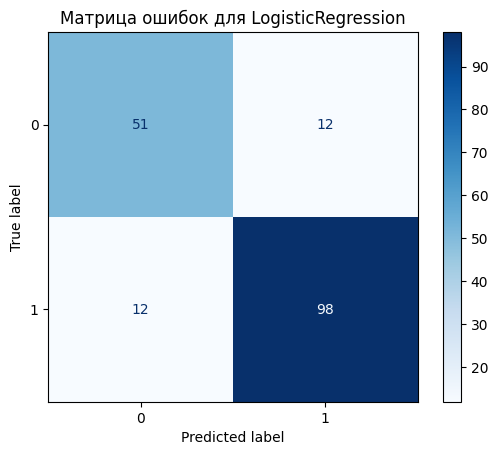


Лучшие параметры для SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
Лучшая оценка для SVM: 0.9768428735272652


2025/05/08 11:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Результаты лучшей модели SVM на тестовой выборке:
Accuracy: 0.976878612716763
Precision: 0.9818181818181818
Recall: 0.9818181818181818
F1 Score: 0.9818181818181818
Лучшая модель SVM сохранена в MLflow Run с ID: 0122474960fa45fc8a8f3e917f6dfede


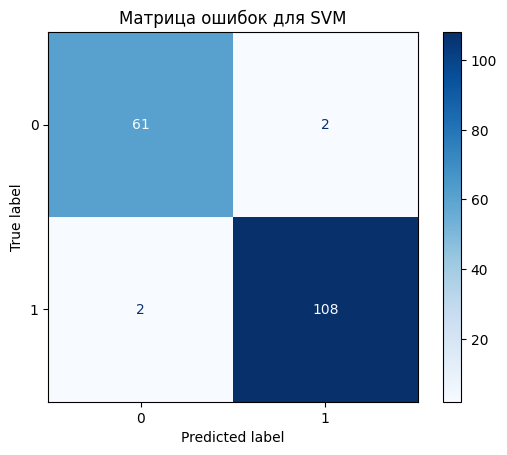


Лучшие параметры для RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Лучшая оценка для RandomForest: 0.946439370242936


2025/05/08 11:47:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Результаты лучшей модели RandomForest на тестовой выборке:
Accuracy: 0.9421965317919075
Precision: 0.9545454545454546
Recall: 0.9545454545454546
F1 Score: 0.9545454545454546
Лучшая модель RandomForest сохранена в MLflow Run с ID: 5671df44e810466985c5b667c7ba86cd


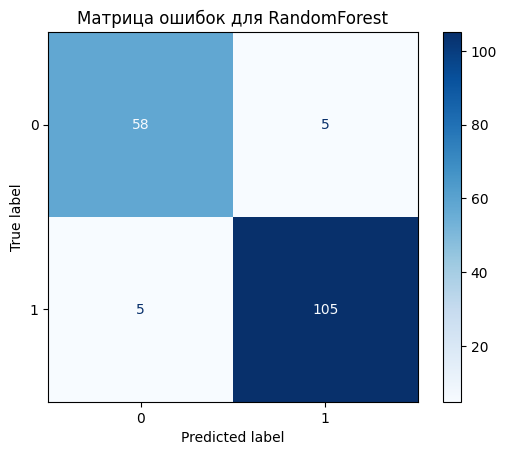

In [190]:
def train_and_log_model(model, param_grid, model_name, X_train_scaled, y_train, X_test_scaled, y_test):
    with mlflow.start_run(run_name=f"{model_name}_tuning"):
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        mlflow.log_params(grid_search.best_params_)
        print(f"\nЛучшие параметры для {model_name}:", grid_search.best_params_)
        print(f"Лучшая оценка для {model_name}:", grid_search.best_score_)

        best_model = grid_search.best_estimator_
        best_model.fit(X_train_scaled, y_train)
        mlflow.sklearn.log_model(best_model, f"best_{model_name}_model")

        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)

        print(f"\nРезультаты лучшей модели {model_name} на тестовой выборке:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Лучшая модель {model_name} сохранена в MLflow Run с ID: {mlflow.active_run().info.run_id}")

        # Вывод матрицы ошибок
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Матрица ошибок для {model_name}')
        plt.show()

        # Сохранение графика матрицы ошибок как артефакта MLflow
        mlflow.log_figure(plt.gcf(), f"confusion_matrix_{model_name}.png")
        plt.close()

# Обучение и логирование каждой модели отдельно
train_and_log_model(LogisticRegression(random_state=42), param_grid_lr, "LogisticRegression",
                    X_train_scaled, y_train, X_test_scaled, y_test)

train_and_log_model(SVC(random_state=42, probability=True), param_grid_svm, "SVM",
                    X_train_scaled, y_train, X_test_scaled, y_test)

train_and_log_model(RandomForestClassifier(random_state=42), param_grid_rf, "RandomForest",
                    X_train_scaled, y_train, X_test_scaled, y_test)

In [271]:
scaler_run = mlflow.search_runs(experiment_names=["Default"], filter_string="tags.mlflow.runName = 'scaler_run'").iloc[0]
scaler_run_id = scaler_run.run_id
scaler_artifact_path = "standard_scaler"
scaler_uri = f"runs:/{scaler_run_id}/{scaler_artifact_path}"
loaded_scaler = mlflow.sklearn.load_model(scaler_uri)
print("Скалер успешно загружен.")

svm_run = mlflow.search_runs(experiment_names=["Default"], filter_string="tags.mlflow.runName = 'SVM_tuning'").iloc[0]
svm_run_id = svm_run.run_id
svm_model_artifact_path = "best_svm_model"
svm_model_uri = f"runs:/{svm_run_id}/{svm_model_artifact_path}"
loaded_svm_model = mlflow.sklearn.load_model(svm_model_uri)
print("Лучшая модель svm успешно загружена.")

Скалер успешно загружен.
Лучшая модель svm успешно загружена.


In [273]:
new_observation = np.array([3.3, 3, 3, 1])
reshaped_observation = new_observation.reshape(1, -1)

scaled_observation = loaded_scaler.transform(reshaped_observation)
print("\nМасштабированное новое наблюдение:")
print(scaled_observation)

prediction = loaded_svm_model.predict(scaled_observation)
print(prediction)
probabilities = loaded_svm_model.predict_proba(scaled_observation)
print(probabilities)


Масштабированное новое наблюдение:
[[-1.30057496 -0.85563164 -0.49892236 -0.16675709]]
[0]
[[0.55079419 0.44920581]]


In [275]:
result_df.to_csv('datasets/final_dataset.csv',index=False, encoding="utf-8-sig")